In [1]:
# display plots in this notebook
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# set display defaults
plt.rcParams['figure.figsize'] = (2, 2) 
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

import numpy as np
from PIL import Image

import sys
caffe_root = '/home/haonans/software/caffe-video_triplet/'
sys.path.insert(0, caffe_root + 'python')

import caffe

caffe.set_mode_gpu()

In [2]:
model_def = '/home/haonans/software/caffe-video_triplet/rank_scripts/rank_alexnet/unsup_net_deploy.prototxt'
model_weights = '/home/haonans/capstone/video_models/unsup_alexnet/video_margin_05_iter_50000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# set the size of the input (we can skip this if we're happy
# with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

In [3]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]

def get_fc7_vector(image_obj):    
    transformed_image = transformer.preprocess('data', image_obj)
    
    net.blobs['data'].data[...] = transformed_image
    output = net.forward()
    fc7_vector = output['fc7'][0]
    
    return np.array(fc7_vector)

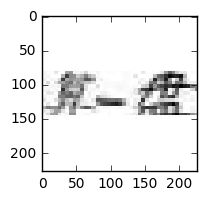

In [4]:
img1 = caffe.io.load_image('/home/haonans/capstone/data/labeled_testing/set1_1.jpg')
plt.imshow(img1)

In [5]:
import os

In [8]:
testing_dir = '/home/haonans/capstone/data/labeled_testing/'
test_fnames = filter(lambda fname: fname[-3:] != 'txt', 
                     map(lambda fname: os.path.join(testing_dir, fname), os.listdir(testing_dir)))
with open('/home/haonans/capstone/data/labeled_testing_fnames.txt', 'w') as writer:
    writer.writelines(map(lambda l: l + '\n', test_fnames))

In [9]:
from scipy.sparse import vstack, csc_matrix

In [10]:
all_sparse_matrix = []
cur_sparse_vectors = []

for i, image_fname in enumerate(test_fnames):
    if i % 100 == 0: print i,
    if i > 0 and i % 1000 == 0:
        all_sparse_matrix.append(vstack(cur_sparse_vectors))
        cur_sparse_vectors = []
    cur_sparse_vectors.append(csc_matrix(get_fc7_vector(caffe.io.load_image(image_fname))))
else:
    print i
    all_sparse_matrix.append(vstack(cur_sparse_vectors))
    cur_sparse_vectors = []

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16534


In [12]:
sparse_matrix = vstack(all_sparse_matrix)

In [1]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=200, init='k-means++', n_jobs=-1, verbose=1)

In [27]:
sparse_matrix.shape

(16535, 1024)

In [ ]:
%timeit kmeans.fit(sparse_matrix)

Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete
Initialization complete


In [ ]:
cluster_assignments = kmeans.predict(np.array(test_vectors))

In [2]:
from scipy import io

io.mmwrite('/home/haonans/capstone/data/labeled_sparse_matrix.mtx', sparse_matrix)
# sparse_matrix = io.mmread('/home/haonans/capstone/data/labeled_sparse_matrix.mtx').tocoo()

In [ ]:
fname_2_label = dict()
with open('/home/haonans/capstone/data/labeled_testing/labels.txt') as reader:
    for line in reader:
        fname, label = line.strip().split()
        fname_2_label[fname] = label

In [ ]:
from collections import defaultdict

cluster_2_labels = defaultdict(list)

for i_fname, i_cluster in enumerate(cluster_assignments):
    fname = int(test_fnames[i_fname].split('/')[-1])
    cur_label = fname_2_label.get(f_name, "XXX")
    cluster_2_labels[i_cluster].append(cur_label)

In [ ]:
for labels in cluster_2_labels.values():
    for l in labels:
        print l,
    else:
        print